## Medical Image Segmentation
### Winter in Data Science by Analytics Club, IIT Bombay
#### Topic: Brain Tumor Segmentation from multi-model 3D MRI images using 3D U-Net architecture
#### Author: Shantanu Welling

Importing relevant libraries

In [79]:
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons, fixed
import os
import cv2
import glob
import PIL
import shutil
import seaborn as sns
import util
sns.set_style('darkgrid')
from keras import backend as K
from tensorflow.keras.models import Model
from keras.layers import (
    Activation,
    Conv3D,
    Input,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from sklearn.model_selection import train_test_split
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical, Sequence
from tensorflow.compat.v1.logging import INFO, set_verbosity
set_verbosity(INFO)
K.set_image_data_format("channels_first")

#### Setting numpy random state

In [80]:
np.random.seed(3)

#### Setting the directory path

In [81]:
dir_path="BraTS2020_TrainingData/BraTS20_Training_"

#### Defining functions to load 3D MRI scans and segment masks along with function to view the 3D image

In [82]:
def getimdata(dirpath,testnum):
    testnum=str(testnum).zfill(3)
    dirpath=dirpath+testnum
    impath=dirpath+"/"+dirpath[-20:]+"_"
    im1=nib.load(impath+"t1.nii")
    im2=nib.load(impath+"t1ce.nii")
    im3=nib.load(impath+"t2.nii")
    im4=nib.load(impath+"flair.nii")
    imdat1=im1.get_fdata()
    imdat2=im2.get_fdata()
    imdat3=im3.get_fdata()
    imdat4=im4.get_fdata()
    res=np.array([imdat4]).reshape((240,240,155,1))
    res=np.append(res, imdat1.reshape((240,240,155,1)), axis=3)
    res=np.append(res, imdat2.reshape((240,240,155,1)), axis=3)
    res=np.append(res, imdat3.reshape((240,240,155,1)), axis=3)
    return res

def explore_3dimage(image_data, channel, layer):
    fig=plt.figure(figsize=(10, 5))
    ax=fig.add_subplot()
    ax.imshow(image_data[:, :, layer, channel], cmap='gray');
    ax.set_title('Explore Layers of Brain MRI', fontsize=20)
    fig.text(.5, .0001,f"Plotting Layer {layer} Channel {channel} of Image",ha="center", fontsize="x-large")
    ax.axis('off')
    return layer

def getmaskdata(dirpath, testnum):
    testnum=str(testnum).zfill(3)
    dirpath=dirpath+testnum
    impath=dirpath+"/"+dirpath[-20:]+"_seg.nii"
    maskobj=nib.load(impath)
    maskimg=maskobj.get_fdata()
    maskimg[maskimg>3]=3
    return maskimg

In [83]:
a1=getimdata(dir_path,1) #Sample image
# Get the image shape and print it out
height, width, depth, channels = a1.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}, channels:{channels}")

The image object has the following dimensions: height: 240, width:240, depth:155, channels:4


Visualize the data using interactive exploration widgets

In [84]:
interact(explore_3dimage, image_data=fixed(a1), channel=fixed(3), layer=(0, a1.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

78

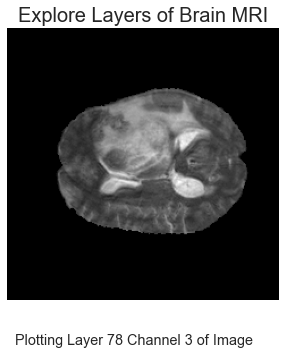

In [85]:
explore_3dimage(a1,3,78)

#### Explore the segmentation masks

In [86]:
mask_img=getmaskdata(dir_path,1)

In [87]:
height, width, depth = mask_img.shape
print(f"Dimensions of mask image array height: {height}, width: {width}, depth: {depth}")
print(f'With the unique values: {np.unique(mask_img)}')
print("""Corresponding to the following label categories: 
0: for normal 
1: for necrotic and non-enhancing tumor 
2: for peritumoral edema 
3: for GD-enhancing tumor""")

Dimensions of mask image array height: 240, width: 240, depth: 155
With the unique values: [0. 1. 2. 3.]
Corresponding to the following label categories: 
0: for normal 
1: for necrotic and non-enhancing tumor 
2: for peritumoral edema 
3: for GD-enhancing tumor


In [88]:
# Define a dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Non-enhancing tumor': 1.,
    'Edema': 2.,
    'Enhancing tumor': 3. 
}

#### Function to visualize the segmentation masks

In [89]:
def visualize_mask(image, layer):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
    for i in range(4):
        img_label_str = list(classes_dict.keys())[i]
        img = mask_img[:,:,layer]
        mask = np.where(img == classes_dict[img_label_str], 255, 0)
        ax[i].imshow(mask)
        ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
        ax[i].axis('off')
    plt.tight_layout()

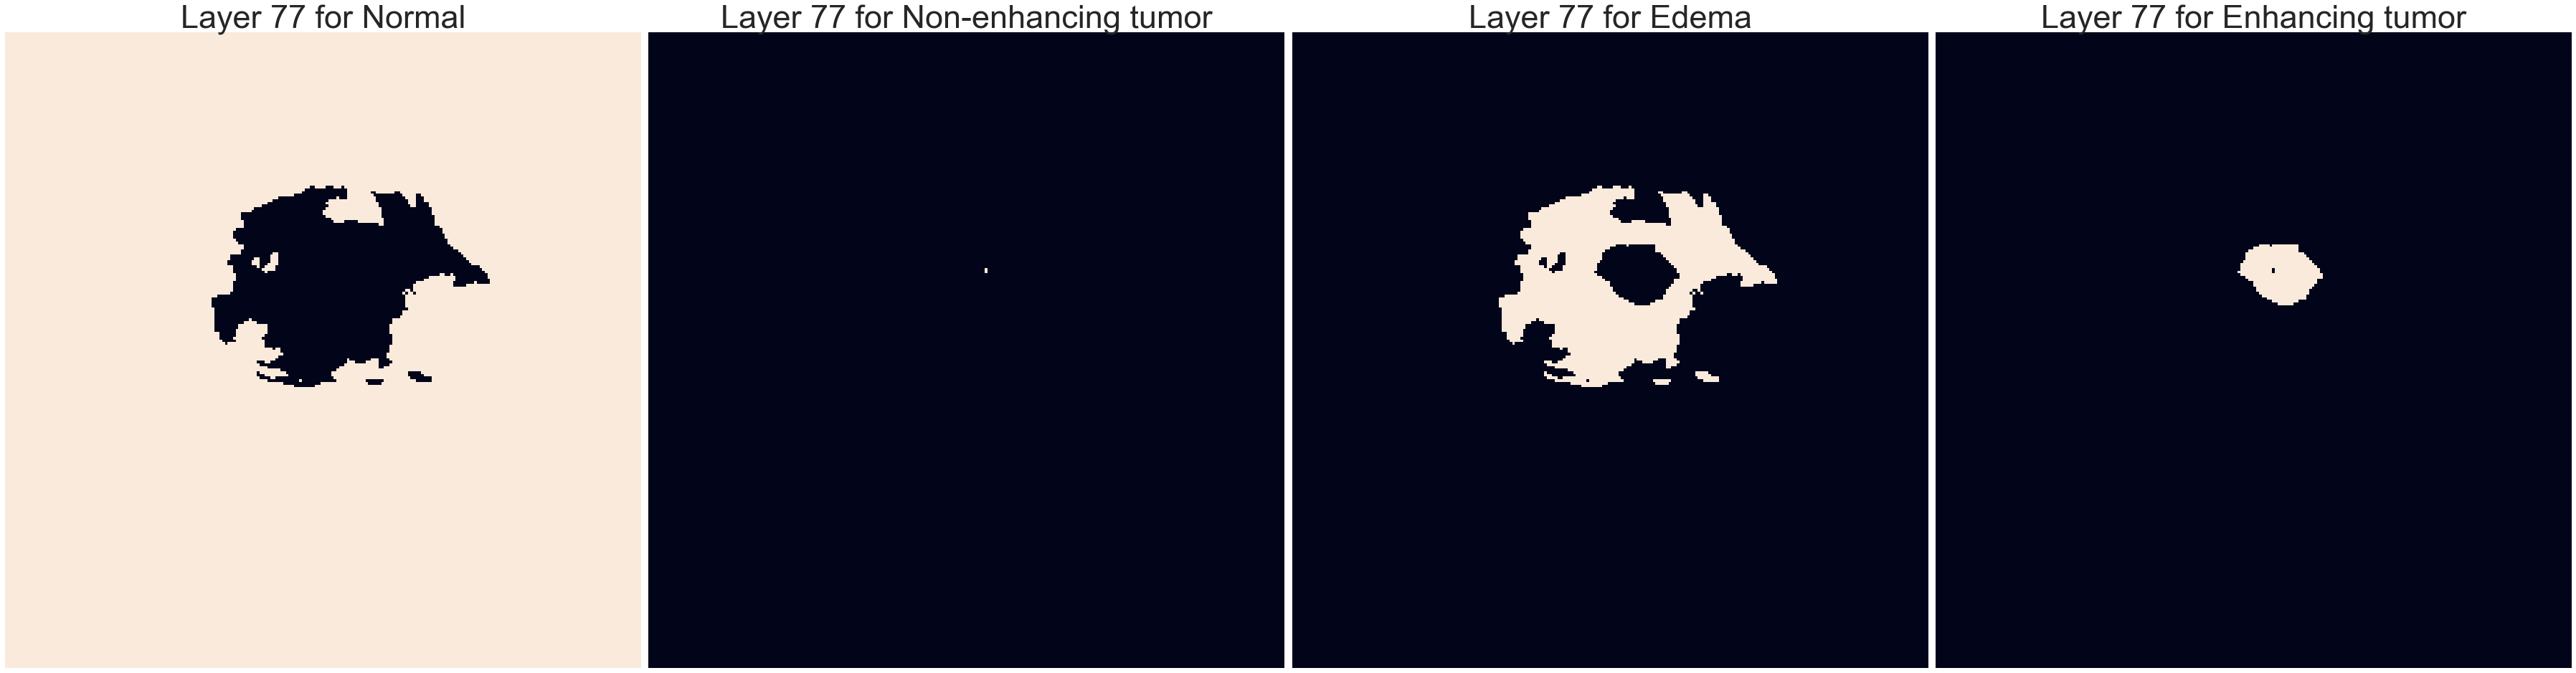

In [90]:
visualize_mask(mask_img,77)

#### Interactive mask visualization

In [91]:
# Create button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info', 
    
)
# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)

    
# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(mask_img[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

The file util.py has functions to visualize data (taken from AI for Medical Diagnosis course on Coursera)
The colors correspond to each class.
- Red is non enhancing tumor
- Green is a edema
- Blue is an enhancing tumor.


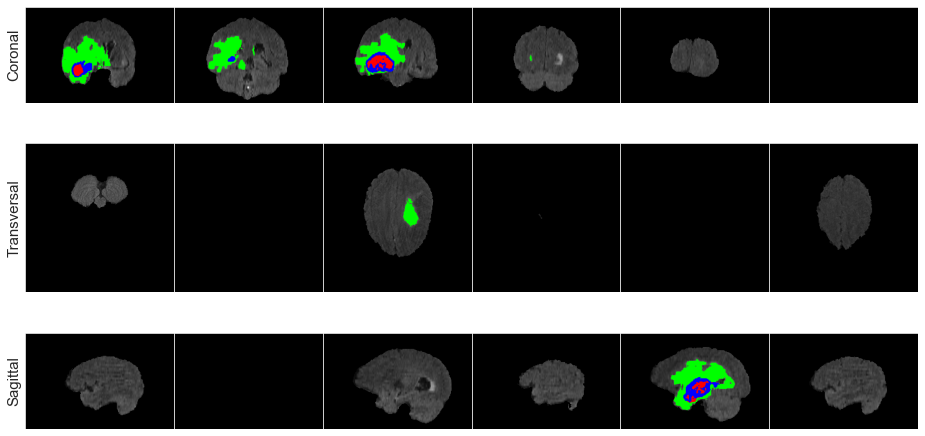

In [92]:
image1=getimdata(dir_path,1)
mask1=getmaskdata(dir_path,1)
im=util.get_labeled_image(image1,mask1)
util.plot_image_grid(im)

#### Standardization, feature scaling and sub-section extraction
Define a function to standard values across each channel and each Z plane to have 0 mean and unit standard deviation.
Sub-section sampling is done because training on a full MRI scan would be too memory intensive to be practical. To extract a sub-section, defined a function to isolate a small "cube" of the data for training.

The function input is:
- a 4D image (shape: \[240, 240, 155, 4\])
- its 3D segmentation mask (shape: \[240, 240, 155\]) arrays, 

The function returns:
 - A randomly generated sub-section of size \[160, 160, 16\]
 - Its corresponding mask which has the shape \[3, 160, 160, 16\]

Additionally: 
1. It makes sure that at most 95% of the returned patch is non-tumor regions. 
2. Given that our network expects the channels for our images to appear as the first dimension (instead of the last one in our current setting) reorder the dimensions of the image to have the channels appear as the first dimension.
3. Reorder the dimensions of the label array to have the first dimension as the classes (instead of the last one in our current setting)
4. Reduce the labels array dimension to only include the non-background classes (total of 3 instead of 4)

In [93]:
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image, 
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label. 
            labels coded using discrete values rather than
            a separate dimension, 
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction 
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None
    tries = 0
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0 , orig_x - output_x + 1)
        start_y = np.random.randint(0 , orig_y - output_y + 1)
        start_z = np.random.randint(0 , orig_z - output_z + 1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = to_categorical(y, num_classes = num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:,:,:,0]) / (output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X,3,0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y,3,0)
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

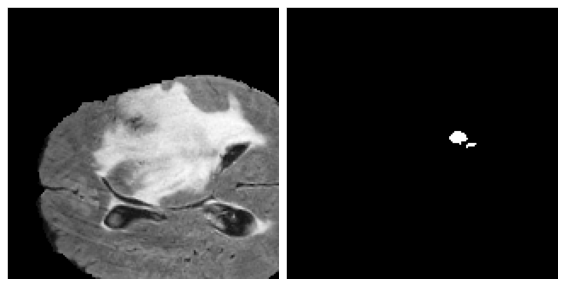

In [94]:
X,y=get_sub_volume(image1,mask1)
util.visualize_patch(X[0, :, :, :], y[2])

In [95]:
def standardize(image):
    """
    Standardize mean and standard deviation 
        of each channel and z_dimension.

    Args:
        image (np.array): input image, 
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """
    standardized_image = np.zeros(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)
            
            # divide by the standard deviation (only if it is different from zero)
            centered_scaled = centered / np.std(centered)

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled
    return standardized_image

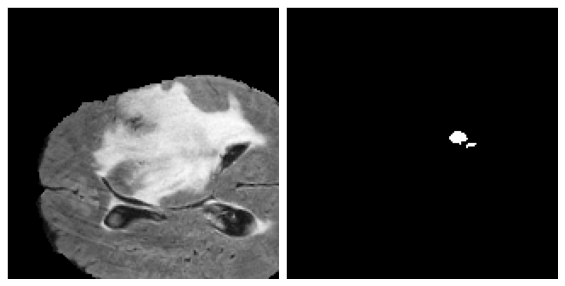

In [96]:
X_norm=standardize(X)
util.visualize_patch(X_norm[0, :, :, :], y[2])

#### Performance Metrics

In [97]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """
    
    dice_numerator = 2 * K.sum(y_true * y_pred , axis = axis) + epsilon
    dice_denominator = K.sum(y_true, axis = axis ) + K.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = K.mean(dice_numerator/dice_denominator)

    return dice_coefficient

In [98]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
            
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,1] * y_pred[:,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,2] * y_pred[:,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,3] * y_pred[:,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [99]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2 * K.sum(y_true * y_pred , axis= axis) + epsilon
    dice_denominator = K.sum(y_true ** 2, axis= axis) + K.sum(y_pred ** 2 , axis = axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)

    return dice_loss

### Building the 3D U-Net Model

In [100]:
metrics=['accuracy', dice_coefficient, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing]
activation_name="sigmoid"

In [101]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)

def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2), strides=(2, 2, 2), deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size, strides=strides)
    else:
        return UpSampling3D(size=pool_size)

In [102]:
def unet_model_3d(loss_function, input_shape=(4, 160, 160, 16),
                  pool_size=(2, 2, 2), n_labels=3,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=2, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                            n_filters=n_base_filters * (
                                                    2 ** layer_depth),
                                            batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                            n_filters=n_base_filters * (
                                                    2 ** layer_depth) * 2,
                                            batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])
        # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=
                                            current_layer.shape[1])(current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1].shape[1],
            input_layer=concat, batch_normalization=batch_normalization)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1].shape[1],
            input_layer=current_layer,
            batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss=loss_function,
                    metrics=metrics)
    return model

In [104]:
model=unet_model_3d(loss_function=soft_dice_loss, metrics=metrics)

In [105]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 4, 160, 160  0           []                               
                                , 16)]                                                            
                                                                                                  
 conv3d_40 (Conv3D)             (None, 32, 160, 160  3488        ['input_6[0][0]']                
                                , 16)                                                             
                                                                                                  
 activation_40 (Activation)     (None, 32, 160, 160  0           ['conv3d_40[0][0]']              
                                , 16)                                                         

In [106]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/'

In [107]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


### Data Generator

In [108]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(160, 160, 16), batch_size = 1, n_channels = 4, shuffle=True,
    n_classes=3, verbose=1):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.n_classes=n_classes
        self.verbose=verbose
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.n_channels, *self.dim),dtype=np.float64)
        y = np.zeros((self.batch_size, self.n_classes, *self.dim), dtype=np.float64)
        
        # Generate data
        for c, i in enumerate(list_IDs_temp):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()   

            data_path = os.path.join(case_path, f'{i}_t1.nii');
            t1 = nib.load(data_path).get_fdata()  

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t2.nii'); 
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            res=np.array([flair]).reshape((240,240,155,1))
            res=np.append(res, t1.reshape((240,240,155,1)), axis=3)
            res=np.append(res, t1ce.reshape((240,240,155,1)), axis=3)
            res=np.append(res, t2.reshape((240,240,155,1)), axis=3)
            seg[seg==4]=3
            print(np.shape(seg), np.shape(res))
            a,b=get_sub_volume(res,seg)
            print(np.shape(a), np.shape(b))
            X[c]=standardize(a)
            y[c]=b
            print(c, np.shape(X), np.shape(y))
        return X,y

In [109]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [110]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
filepath="3D-UNet-2018-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5" 

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
csv_logger = CSVLogger('training_2020_3D_UNet.log')


In [111]:
steps_per_epoch = 20
n_epochs=10
validation_steps = 20

In [112]:
history=model.fit(training_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        use_multiprocessing=True,
        validation_data=valid_generator,
        validation_steps=validation_steps)

(240, 240, 155) (240, 240, 155, 4)
(4, 160, 160, 16) (3, 160, 160, 16)
0 (1, 4, 160, 160, 16) (1, 3, 160, 160, 16)
Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/model/conv3d_46/Conv3D/Conv3DBackpropFilterV2' defined at (most recent call last):
    File "c:\Shantanu\Anaconda\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Shantanu\Anaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Shantanu\Anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Shantanu\Anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Shantanu\Anaconda\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Shantanu\Anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Shantanu\Anaconda\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Shantanu\Anaconda\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Shantanu\Anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Shantanu\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "c:\Shantanu\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "c:\Shantanu\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "c:\Shantanu\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "c:\Shantanu\Anaconda\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Shantanu\Anaconda\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\Shantanu\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "c:\Shantanu\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "c:\Shantanu\Anaconda\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Shantanu\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Shantanu\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Shantanu\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\SHANTA~1\AppData\Local\Temp/ipykernel_7256/181255490.py", line 1, in <module>
      history=model.fit(training_generator,
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "c:\Shantanu\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/conv3d_46/Conv3D/Conv3DBackpropFilterV2'
Conv3DBackpropFilterOpV2 only supports NDHWC on the CPU.
	 [[{{node gradient_tape/model/conv3d_46/Conv3D/Conv3DBackpropFilterV2}}]] [Op:__inference_train_function_5270]